
# <span style="color:#0b486b">Deep Neural Networks and Text Analytics - PML 2</span>

The aim of this project is to demonstrate the creation of a simple machine learning pipeline

**Setup + Explore Data**

In [1]:
# Setup
import pandas as pd
import numpy as np
import scipy.io as sio
import itertools
data = sio.matlab.loadmat("datasets/notMNIST_small.mat")

x, y = data["images"], data["labels"]
x = np.rollaxis(x, axis=2)

In [3]:
print("Total Number of Data Points")
print()
num_datapoints = len(x)
print('The number of data points is: {}'.format(num_datapoints))
print()

unique_labels = np.unique(y)
print('The Unique labels are: {}'.format(unique_labels))

Total Number of Data Points

The number of data points is: 18724

The Unique labels are: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


**Displaying the Data Images**

In [4]:
# this function is a utility to display images from the dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def display_images(images, shape):
    fig = plt.figure(figsize=shape)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(np.prod(shape)):
        p = fig.add_subplot(shape[0], shape[1], i+1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)    

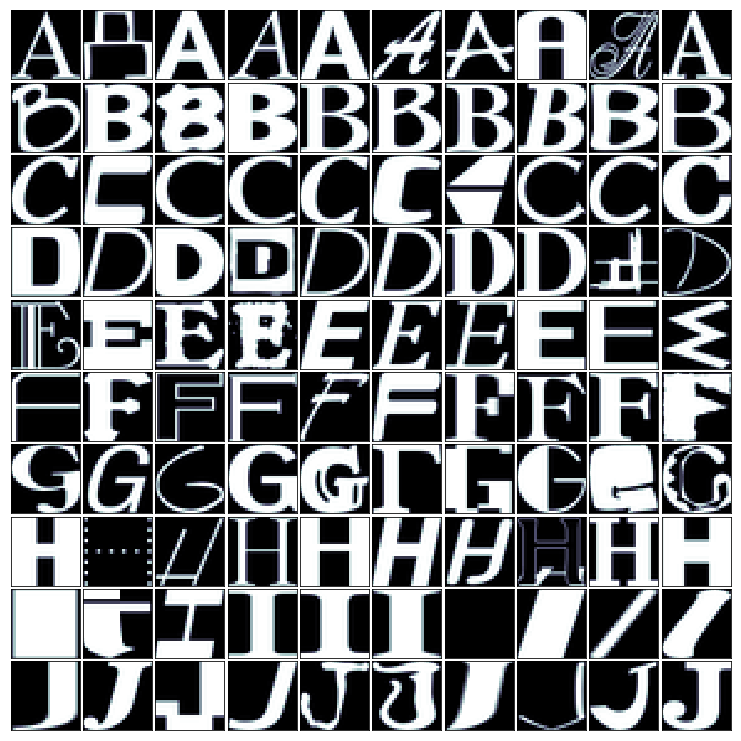

In [5]:
images = []
for l in unique_labels:    
    idx = np.where(y == l)[0]
    idx = idx[np.random.permutation(len(idx))[:10]]    
    for i in idx:
        images += [x[i,...]]

display_images(images, shape=(10, 10))

In [6]:
# Reshaping the data to make it more useable - 
# Changing from [num_samples, width, height] to -
# [num_samples, num_features] with num_features = width x height

num_samples = x.shape[0]
x = x.reshape(num_samples,-1)
print(x)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   1.   0. ... 175.  75.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...  63.  22.   1.]]


In [7]:
# Rescaling the data to range of [0,1]
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
#Fit Scaler
scaler.fit(x)
#print(scaler.data_max_)

images_scaled = scaler.transform(x)
images_scaled

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00392157, 0.        , ..., 0.68627451, 0.29411765,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.24705882, 0.08627451,
        0.00392157]])

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

idx_train, idx_test = next(StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42).split(images_scaled, y))
x_train, y_train = images_scaled[idx_train], y[idx_train]
x_test, y_test = images_scaled[idx_test], y[idx_test]

**Constructing a Deep Feedforward Neural Network using Tensorflow**

In [9]:
import tensorflow as tf

tf.reset_default_graph()

num_inputs = images_scaled.shape[1]
num_hidden1 = 500
num_hidden2 = 500
num_outputs = len(np.unique(y))

inputs = x_train
labels = y_train

inputs = tf.placeholder(tf.float32, shape=[None, num_inputs], name="inputs")
labels = tf.placeholder(tf.int32, shape=[None], name="labels")

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
def neuron_layer(x, num_neurons, name, activation=None):
    with tf.name_scope(name):
        num_inputs =  int(x.get_shape()[1])
        stddev = 2 / np.sqrt(num_inputs)
        init = tf.truncated_normal([num_inputs, num_neurons], stddev=stddev)
        w = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([num_neurons]), name="biases")
        z = tf.matmul(x, w) + b
    if activation == "sigmoid":
        return tf.nn.sigmoid(z)
    elif activation == "relu":
        return tf.nn.relu(z)
    else:
        return z

In [11]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(inputs, num_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, num_hidden2, "hidden2", activation="relu")
    logits = neuron_layer(hidden2, num_outputs, "output")
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, 
                                                              logits=logits, 
                                                              name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("evaluation"):
    correct = tf.nn.in_top_k(logits, labels, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("train"):
    learning_rate = 0.01
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads = optimizer.compute_gradients(loss)    
    training_op = optimizer.apply_gradients(grads)
    
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name + "/values", var)
        
    for grad, var in grads:
        if grad is not None:
            tf.summary.histogram(var.op.name + "/gradients", grad)
    


# summary
accuracy_summary =  tf.summary.scalar("accuracy", accuracy)

In [12]:
# merge all summary
tf.summary.histogram('hidden1/activations', hidden1)
tf.summary.histogram('hidden2/activations', hidden2)
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()
saver = tf.train.Saver()

train_writer = tf.summary.FileWriter("models/dnn0/train", tf.get_default_graph())
test_writer = tf.summary.FileWriter("models/dnn0/test", tf.get_default_graph())

num_epochs = 50
batch_size = 128

**Training the DNN**

In [13]:
with tf.Session() as sess:
    init.run()
    print("Epoch\tTrain accuracy\tTest accuracy")
    for epoch in range(num_epochs):
        for idx_start in range(0, x_train.shape[0], batch_size):
            idx_end = min(x_train.shape[0], idx_start + batch_size)
            x_batch, y_batch = x_train[idx_start:idx_end], y_train[idx_start:idx_end]
            sess.run(training_op, feed_dict={inputs: x_batch, labels: y_batch})
            
        summary_train, acc_train = sess.run([merged, accuracy], feed_dict={inputs: x_train, labels: y_train})
        summary_test, acc_test = sess.run([accuracy_summary, accuracy], feed_dict={inputs: x_test, labels: y_test})
        
        train_writer.add_summary(summary_train, epoch)
        test_writer.add_summary(summary_test, epoch)
        
        print("{}\t{}\t{}".format(epoch, acc_train, acc_test))

    save_path = saver.save(sess, "models/dnn0.ckpt")

Epoch	Train accuracy	Test accuracy
0	0.8422859907150269	0.8374866247177124
1	0.8670074939727783	0.8636525273323059
2	0.87677401304245	0.8727304935455322
3	0.8844804167747498	0.8803845047950745
4	0.889974057674408	0.8843004703521729
5	0.8937128186225891	0.8875044584274292
6	0.8979856371879578	0.8896404504776001
7	0.9007325172424316	0.8912424445152283
8	0.9042423367500305	0.8935564160346985
9	0.9069891571998596	0.8951584100723267
10	0.9095833897590637	0.8962264060974121
11	0.9119487404823303	0.897650420665741
12	0.9137799739837646	0.8988963961601257
13	0.9158400893211365	0.8996083736419678
14	0.9179764986038208	0.8994303941726685
15	0.9196551442146301	0.8999643921852112
16	0.9217915534973145	0.901210367679596
17	0.9232412576675415	0.9008544087409973
18	0.9243857860565186	0.90138840675354
19	0.9259117841720581	0.9017443656921387
20	0.9278956055641174	0.9017443656921387
21	0.9296505451202393	0.9022783637046814
22	0.9306424260139465	0.9033463597297668
23	0.9320921897888184	0.903880357742309


# <span style="color:#0b486b">Part 2: Text Analytics using Word2Vec</span>

In [14]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers'))

In [15]:
import numpy as np

print(f"Number of data points: {len(newsgroups_all.target)}")
print(f"Unique labels: {np.unique(newsgroups_all.target)}")

Number of data points: 18846
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [16]:
import gensim

docs = [list(gensim.utils.tokenize(text, lowercase=True)) for text in newsgroups_all.data]

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


**Train the Model - Using Gensim's Word2Vec**

In [18]:
from gensim.models import Word2Vec

model = Word2Vec(docs, size=100, window=5, min_count=5, workers=8)

In [19]:
# Save Model
model.save("20_newsgroups.gensim")

In [20]:
print(f"Vocabulary size: {len(model.wv.vocab)}")

Vocabulary size: 34985


In [21]:
print("10 Most similar words to the word 'Law' and their similarity scores")
model.wv.most_similar(positive='law')

10 Most similar words to the word 'Law' and their similarity scores


C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('constitution', 0.6949051022529602),
 ('laws', 0.6691154837608337),
 ('court', 0.6684303283691406),
 ('act', 0.6380288600921631),
 ('state', 0.6359252333641052),
 ('legitimate', 0.6340131759643555),
 ('enforcement', 0.6327090263366699),
 ('federal', 0.6297199726104736),
 ('marriage', 0.629707932472229),
 ('government', 0.6228223443031311)]

**Evaluate the Embeddings using Classification**

2 approaches used here:
- Sum of Vectors
- Average of Vectors


In [24]:
# Extract document vectors using sum

# Empty documents are removed. A Document = empty when - 
# It doesn't contain any word in the vocabulary

# Doc Variables = x. Doc Labels = y
    
def extract_doc2vec(doc, w2v):
    vecs = [w2v[word] for word in doc if word in w2v]
    if len(vecs) > 0:
        vecs = np.asarray(vecs).sum(axis=0)
    return vecs

vecs = [extract_doc2vec(doc, model) for doc in docs]
to_keep = [len(v)>0 for v in vecs]

from itertools import compress
x = np.asarray(list(compress(vecs, to_keep)))
y = np.asarray(list(compress(newsgroups_all.target, to_keep)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [25]:
print('Number of documents after removing empties')
print(len(y))

Number of documents after removing empties
18809


In [26]:
# Data Train-Test Split (70-30) using StratifiedShuffleSplit 

from sklearn.model_selection import StratifiedShuffleSplit

idx_train, idx_test = next(StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=6789).split(x, y))
x_train, y_train = x[idx_train], y[idx_train]
x_test, y_test = x[idx_test], y[idx_test]

Logistic Regression Classifier on **Sum**

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

Train accuracy: 0.6033723226492481
Test accuracy: 0.570086833244728


Simplified Function for **Average**

In [28]:
def extract_doc2vec(doc, w2v):
    vecs = [w2v[word] for word in doc if word in w2v]
    if len(vecs) > 0:
        vecs = np.asarray(vecs).mean(axis=0)
    return vecs

vecs = [extract_doc2vec(doc, model) for doc in docs]

x = np.asarray(list(compress(vecs, to_keep)))

x_train, x_test = x[idx_train], x[idx_test]
 
lr = LogisticRegression()
lr.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred)}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred)}")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Train accuracy: 0.6380069876955795
Test accuracy: 0.6097820308346624
